In [3]:
import math
import copy
from typing import List
from matrix import CSRMatrix as Matrix 
from decimal import Decimal, getcontext

In [4]:
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from mpl_toolkits.mplot3d import Axes3D

# Сама лаба


## Easy


### Метод гауса


In [5]:
def gauss_solver(A: 'Matrix', b: 'Matrix') -> List['Matrix']:
    n = A.size
    augmented = A.augment(b)  # Расширенная матрица [A|b]
    
    # Прямой ход: приведение к ступенчатому виду
    rank = 0
    pivot_cols = []
    for col in range(augmented.cols - 1):  # Исключаем последний столбец (вектор b)
        # Поиск ненулевого элемента в текущем столбце
        pivot_row = -1
        for row in range(rank, n):
            if abs(augmented[row][col]) > 1e-10:
                pivot_row = row
                break
        if pivot_row == -1:
            continue  # Все элементы столбца нулевые
        
        # Перестановка строк
        augmented.swap_rows(rank, pivot_row)
        # Нормализация ведущей строки
        pivot = augmented[rank][col]
        for c in range(col, augmented.cols):
            augmented[rank][c] /= pivot
        # Исключение элементов ниже ведущего
        for row in range(rank + 1, n):
            factor = augmented[row][col]
            for c in range(col, augmented.cols):
                augmented[row][c] -= factor * augmented[rank][c]
        pivot_cols.append(col)
        rank += 1

    # Проверка на несовместность
    for row in range(rank, n):
        if abs(augmented[row][-1]) > 1e-10:
            raise ValueError("Система несовместна")

    # Определение свободных переменных
    all_vars = list(range(A.cols))
    leading_vars = pivot_cols
    free_vars = [var for var in all_vars if var not in leading_vars]
    
    # Если нет свободных переменных: единственное решение
    if not free_vars:
        x = [0] * A.cols
        for row in reversed(range(rank)):
            x[leading_vars[row]] = augmented[row][-1]
            for col in range(leading_vars[row] + 1, A.cols):
                x[leading_vars[row]] -= augmented[row][col] * x[col]
        return [Matrix([x])]

    # Построение базисных векторов
    basis = []
    for var in free_vars:
        solution = [0] * A.cols
        solution[var] = 1  # Свободная переменная = 1
        # Вычисление главных переменных
        for row in reversed(range(rank)):
            col = leading_vars[row]
            solution[col] = augmented[row][-1]
            for c in range(col + 1, A.cols):
                solution[col] -= augmented[row][c] * solution[c]
        basis.append(Matrix([solution]))
    
    return basis


In [6]:

# A = Matrix([ [1, 2, 3], [4, 5, 6],
#     [7, 8, 9]
# ])
# b = Matrix([[6], [15], [24]])

# solutions = gauss_solver(A, b)  # Возвращает базисные векторы (если система неопределённа)

### Центрирование данных


In [7]:
def center_data(X: 'Matrix') -> 'Matrix':
    """
    Centers the data matrix X by subtracting the mean of each column.

    Input: data matrix X (n x m)
    Output: centered matrix X_centered (n x m)
    """
    n, m = X.size

    if n == 0 or m == 0:
        return type(X)([])

    column_means = [0.0] * m
    x_list = X.to_list()

    for row in x_list:
        for j in range(m):
            column_means[j] += float(row[j]) / n


    mean_matrix_list = [column_means[:] for _ in range(n)]
    mean_matrix = type(X)(mean_matrix_list)

    X_centered = X - mean_matrix

    return X_centered

In [8]:
# Tests
matrix1 = Matrix([[1.0, 2.0],
         [3.0, 4.0],
         [5.0, 6.0]])

centered_matrix1 = center_data(matrix1)
print(centered_matrix1, end='\n\n')

matrix2= Matrix([[-1.0, 10.0],
         [ 0.0,  0.0],
         [ 1.0, -10.0]])

centered_matrix2 = center_data(matrix2)
print(centered_matrix2, end='\n\n')

matrix3 = Matrix([[1, 2, 3]])
centered_matrix3 = center_data(matrix3)
print(centered_matrix3, end ='\n\n')

matrix4 = Matrix([[1, 2, 3]]).transpose()
centered_matrix3 = center_data(matrix4)
print(centered_matrix3, end='\n\n')


[
 [-2.0 -2.0]
 [ 0.0  0.0]
 [ 2.0  2.0]
]

[
 [-1.0  10.0]
 [ 0.0   0.0]
 [ 1.0 -10.0]
]

[
 [0.0 0.0 0.0]
]

[
 [-1.0]
 [ 0.0]
 [ 1.0]
]



### Вычислить матрицу ковариаций


In [9]:
def covariance_matrix(X_centered: 'Matrix') -> 'Matrix':
    """
    Вход: центрированная матрица X_centered (n×m)
    Выход: матрица ковариаций C (m×m)
    """
    n, m = X_centered.size
    if n <= 1:
        print('z')
        return Matrix([[0] * m] * m)
    return X_centered.transpose() * X_centered * (1/(n-1))

In [10]:
# --- Tests ---


data1_centered = Matrix([[1, -1], [-1, 1]])
cov_matrix1 = covariance_matrix(data1_centered)
print("Input X_centered:")
print(data1_centered)
print("Computed Covariance Matrix:")
print(cov_matrix1)
expected_cov1 = Matrix([[Decimal(2), Decimal(-2)], [Decimal(-2), Decimal(2)]])
print("-" * 20)


data2_centered = Matrix([[1, 2, 3], [0, 0, 0], [-1, -2, -3]])
cov_matrix2 = covariance_matrix(data2_centered)
print("Input X_centered:")
print(data2_centered)
print("Computed Covariance Matrix:")
print(cov_matrix2)
expected_cov2 = Matrix([[Decimal(1), Decimal(2), Decimal(3)], [Decimal(2), Decimal(4), Decimal(6)], [Decimal(3), Decimal(6), Decimal(9)]])
print("-" * 20)

# Test case 3: Matrix with one sample (should handle this edge case)
print("Test Case 3 (Single Sample):")
data3_centered = Matrix([[10, 20]])
cov_matrix3 = covariance_matrix(data3_centered)
print("Input X_centered:")
print(data3_centered)
print("Computed Covariance Matrix:")
print(cov_matrix3)
expected_cov3 = Matrix([[Decimal(0), Decimal(0)], [Decimal(0), Decimal(0)]])
print("-" * 20)

Input X_centered:
[
 [ 1 -1]
 [-1  1]
]
Computed Covariance Matrix:
[
 [ 2.0 -2.0]
 [-2.0  2.0]
]
--------------------
Input X_centered:
[
 [ 1  2  3]
 [ 0  0  0]
 [-1 -2 -3]
]
Computed Covariance Matrix:
[
 [1.0 2.0 3.0]
 [2.0 4.0 6.0]
 [3.0 6.0 9.0]
]
--------------------
Test Case 3 (Single Sample):
z
Input X_centered:
[
 [10 20]
]
Computed Covariance Matrix:
[
 [0 0]
 [0 0]
]
--------------------


## Normal


### Jacobi method to find eigenvalues and eigenvectors

In [11]:
def identity_matrix(size: int, dtype: type) -> 'Matrix':
    """Creates an identity matrix of given size and dtype."""
    if size <= 0:
        raise ValueError("Size must be positive.")
    # Initialize with appropriate zero and one based on dtype
    zero_val = dtype(0)
    one_val = dtype(1) if dtype is not complex else complex(1)

    mat = [[zero_val] * size for _ in range(size)]
    for i in range(size):
        mat[i][i] = one_val
    return Matrix(mat)

def get_column_as_vector(matrix: 'Matrix', col_idx: int) -> 'Matrix':
    """Extracts a column from a matrix and returns it as a column vector."""
    if not 0 <= col_idx < matrix.size[1]:
        raise IndexError(f"Column index {col_idx} out of bounds for matrix size {matrix.size}.")
    return Matrix([[matrix[i, col_idx]] for i in range(matrix.size[0])])


def jacobi_step(A: 'Matrix', V: 'Matrix', p: int, q: int, angle: float) -> tuple['Matrix', 'Matrix']:
    """
    Выполняет один шаг метода Якоби (вращение) и обновляет матрицу собственных векторов.

    Вход:
    A: текущая матрица (будет преобразована)
    V: текущая матрица собственных векторов (будет преобразована)
    p, q: индексы внедиагонального элемента
    angle: угол поворота
    Выход: кортеж (преобразованная матрица A', преобразованная матрица V')
    """
    n = A.size[0]
    cos_a = math.cos(float(angle))
    sin_a = math.sin(float(angle))
    dtype = A.dtype

    # Construct the rotation matrix J(p, q, angle)
    J_data = [[dtype(0)] * n for _ in range(n)]
    one_val = dtype(1) if dtype is not complex else complex(1)

    for k in range(n):
        J_data[k][k] = one_val

    J_data[p][p] = dtype(cos_a) if dtype is not complex else complex(cos_a)
    J_data[q][q] = dtype(cos_a) if dtype is not complex else complex(cos_a)
    J_data[p][q] = dtype(sin_a) if dtype is not complex else complex(sin_a)
    J_data[q][p] = dtype(-sin_a) if dtype is not complex else complex(-sin_a)

    J = Matrix(J_data)

    # Apply the transformation A' = J^T * A * J
    J_transpose = J.transpose()
    A_prime = (J_transpose * A) * J

    # Update the eigenvector matrix V' = V * J
    V_prime = V * J

    return A_prime, V_prime


def jacobi_eigen_decomposition(
    C: "Matrix", tol: float = 1e-7, max_iterations: int = 100
) -> tuple['Matrix', 'Matrix']:
    """
    Выполняет итерации метода Якоби для приведения симметричной матрицы к диагональному виду
    и нахождения матрицы собственных векторов.

    Вход:
    C: симметричная матрица (m×m)
    tol: допустимая погрешность (максимальное абсолютное значение внедиагонального элемента)
    max_iterations: максимальное количество итераций
    Выход: кортеж (матрица с собственными значениями на диагонали, матрица собственных векторов)
    """
    if C.size[0] != C.size[1]:
        raise ValueError("Input matrix must be square.")
    if C.dtype is complex:
        raise TypeError("Jacobi method implementation expects a real matrix.")

    n = C.size[0]
    A = C.copy()
    V = identity_matrix(n, A.dtype) 

    for iteration in range(max_iterations):
        # Find the largest off-diagonal element (in absolute value)
        max_val = 0
        p, q = 0, 0
        for i in range(n):
            for j in range(i + 1, n): 
                abs_val = abs(A[i, j])
                if abs_val > max_val:
                    max_val = abs_val
                    p, q = i, j

        if max_val < tol:
            break

        # Calculate rotation angle
        app = A[p, p]
        aqq = A[q, q]
        apq = A[p, q]

        # Calculate tan(2*theta) and then theta
        denominator = app - aqq
        if abs(denominator) < 1e-12: # Use a small epsilon for comparison
            angle = math.pi / 4.0 if apq >= 0 else -math.pi / 4.0
        else:
            angle = math.atan2(2.0 * float(apq), float(denominator)) / 2.0

        A, V = jacobi_step(A, V, p, q, angle)

    return A, V


def find_eigenvalues_and_vectors(
    C: "Matrix", tol: float = 1e-7, max_iterations: int = 100
) -> list[tuple[float, 'Matrix']]:
    """
    Находит собственные значения и соответствующие им собственные векторы симметричной матрицы методом Якоби.

    Вход:
    C: симметричная матрица ковариаций (m×m)
    tol: допустимая погрешность (максимальное абсолютное значение внедиагонального элемента)
    max_iterations: максимальное количество итераций
    Выход: список кортежей (собственное значение, собственный вектор), отсортированный по убыванию собственных значений.
           Каждый собственный вектор - объект Matrix (столбец).
    """
    # Perform the Jacobi decomposition to get the diagonalized matrix and eigenvector matrix
    diagonalized_matrix, eigenvector_matrix = jacobi_eigen_decomposition(C, tol, max_iterations)

    n = diagonalized_matrix.size[0]
    eigen_pairs = []

    # Extract eigenvalues from the diagonal and corresponding eigenvectors from the columns of V
    for i in range(n):
        eigenvalue = float(diagonalized_matrix[i, i])
        eigenvector = get_column_as_vector(eigenvector_matrix, i)
        eigen_pairs.append((eigenvalue, eigenvector))

    # Sort the eigen-pairs by eigenvalue in descending order
    eigen_pairs.sort(key=lambda pair: pair[0], reverse=True)

    return eigen_pairs

### Собственные значения матрицы


In [12]:
def find_eigenvalues(
    C: "Matrix", tol: float = 1e-6, max_iterations: int = 100
) -> list[float]:
    """
    Находит собственные значения симметричной матрицы методом Якоби.

    Вход:
    C: симметричная матрица ковариаций (m×m)
    tol: допустимая погрешность (максимальное абсолютное значение внедиагонального элемента)
    max_iterations: максимальное количество итераций
    Выход: список вещественных собственных значений, отсортированный по убыванию.
    """
    eigen_pairs = find_eigenvalues_and_vectors(C, tol, max_iterations)
    return [pair[0] for pair in eigen_pairs]

### Собственные векторы матрицы


In [13]:

def find_eigenvectors(C: 'Matrix', tol: float = 1e-6, max_iterations: int = 100) -> List['Matrix']:
    """
    Находит собственные векторы симметричной матрицы методом Якоби.
    ВАЖНО: Собственные векторы соответствуют собственным значениям,
    возвращаемым функцией find_eigenvalues, в том же порядке.

    Вход:
    C: симметричная матрица ковариаций (m×m)
    tol: допустимая погрешность
    max_iterations: максимальное количество итераций
    Выход: список собственных векторов (каждый вектор - объект Matrix столбец),
           отсортированный в соответствии с убывающими собственными значениями.
    """
    eigen_pairs = find_eigenvalues_and_vectors(C, tol, max_iterations)
    return [pair[1] for pair in eigen_pairs]



In [14]:
# --- Тесты функций ---
print("Тестируем функцию find_eigenvalues_and_vectors:")

# Пример симметричной матрицы 2x2 с известными собственными значениями (3 и 1)
# Matrix: [[2, 1], [1, 2]]
# Eigenvectors should be proportional to [1, 1] and [-1, 1] (or [1, -1]), orthonormal: approx [0.707, 0.707] and [-0.707, 0.707]
matrix_data_2x2 = [[2.0, 1.0], [1.0, 2.0]]
mat_2x2 = Matrix(matrix_data_2x2)

eigen_pairs_2x2 = find_eigenvalues_and_vectors(mat_2x2)
print(f"Матрица:\n{mat_2x2}")
print(f"Найденные пары (собственное значение, собственный вектор):\n{[(v, str(m)) for v, m in eigen_pairs_2x2]}")
# Ожидаемые пары: примерно (3.0, [[0.707], [0.707]]), (1.0, [[-0.707], [0.707]]) или аналогичные с другими знаками/порядком векторов для повторяющихся значений


print("\nТестируем функцию find_eigenvalues (использует find_eigenvalues_and_vectors):")
eigenvalues_2x2 = find_eigenvalues(mat_2x2)
print(f"Найденные собственные значения: {eigenvalues_2x2}")
# Ожидаемые собственные значения: примерно [3.0, 1.0]

print("\nТестируем функцию find_eigenvectors (использует find_eigenvalues_and_vectors):")
eigenvectors_2x2 = find_eigenvectors(mat_2x2)
print(f"Найденные собственные векторы:\n{[str(m) for m in eigenvectors_2x2]}")
# Ожидаемые собственные векторы: примерно [[0.707], [0.707]] и [[-0.707], [0.707]]


print("\n" + "="*30 + "\n")

# Пример симметричной матрицы 3x3
# Matrix: [[4, 1, 2], [1, 5, 0], [2, 0, 3]]
# Eigenvalues are approx 6.44, 3.10, 2.45
matrix_data_3x3 = [[4.0, 1.0, 2.0], [1.0, 5.0, 0.0], [2.0, 0.0, 3.0]]
mat_3x3 = Matrix(matrix_data_3x3)

eigen_pairs_3x3 = find_eigenvalues_and_vectors(mat_3x3)
print(f"Матрица:\n{mat_3x3}")
print(f"Найденные пары (собственное значение, собственный вектор):\n{eigen_pairs_3x3}")

print("\nТестируем функцию find_eigenvalues (использует find_eigenvalues_and_vectors):")
eigenvalues_3x3 = find_eigenvalues(mat_3x3)
print(f"Найденные собственные значения: {eigenvalues_3x3}")

print("\nТестируем функцию find_eigenvectors (использует find_eigenvalues_and_vectors):")
eigenvectors_3x3 = find_eigenvectors(mat_3x3)
print(f"Найденные собственные векторы:\n{eigenvectors_3x3}")

Тестируем функцию find_eigenvalues_and_vectors:
Матрица:
[
 [2.0 1.0]
 [1.0 2.0]
]
Найденные пары (собственное значение, собственный вектор):
[(3.0, '[\n [0.70711]\n [0.70711]\n]'), (1.0, '[\n [ 0.70711]\n [-0.70711]\n]')]

Тестируем функцию find_eigenvalues (использует find_eigenvalues_and_vectors):
Найденные собственные значения: [3.0, 1.0]

Тестируем функцию find_eigenvectors (использует find_eigenvalues_and_vectors):
Найденные собственные векторы:
['[\n [0.70711]\n [0.70711]\n]', '[\n [ 0.70711]\n [-0.70711]\n]']


Матрица:
[
 [4.0 1.0 2.0]
 [1.0 5.0 0.0]
 [2.0 0.0 3.0]
]
Найденные пары (собственное значение, собственный вектор):
[(5.804112903938886, <matrix.CSRMatrix object at 0x7d611ba49710>), (4.86274801912311, <matrix.CSRMatrix object at 0x7d611ba49cc0>), (1.3331390769379987, <matrix.CSRMatrix object at 0x7d611ba49a20>)]

Тестируем функцию find_eigenvalues (использует find_eigenvalues_and_vectors):
Найденные собственные значения: [5.804112903938886, 4.86274801912311, 1.33313907

### доля объясненной дисперсии


In [15]:
def explained_variance_ratio(eigenvalues: List[float], k: int) -> float:
    """
    Вычисляет долю общей дисперсии, объясненной первыми k главными компонентами.

    Вход:
    eigenvalues: список вещественных собственных значений, отсортированный по убыванию.
    k: число главных компонент (1 <= k <= len(eigenvalues)).
    Выход: доля объяснённой дисперсии (значение от 0.0 до 1.0).
           Возвращает 0.0, если сумма собственных значений равна 0.
    """
    if not eigenvalues:
        return 0.0  # No variance if no eigenvalues

    if not (1 <= k <= len(eigenvalues)):
        raise ValueError("k must be between 1 and the number of eigenvalues.")

    total_variance = sum(eigenvalues)

    if total_variance == 0:
        return 0.0 

    # Sum of the first k eigenvalues (variance explained by top k components)
    variance_k_components = sum(eigenvalues[:k])

    return variance_k_components / total_variance
    


In [16]:
# --- Тесты функции explained_variance_ratio ---
print("\n" + "=" * 30 + "\n")
print("Тестируем функцию explained_variance_ratio:")

# Пример 1: Простые собственные значения
# Общая дисперсия = 5 + 3 + 1 = 9
eigenvalues_test1 = [5.0, 3.0, 1.0]
print(f"Собственные значения: {eigenvalues_test1}")

# k = 1
k1 = 1
ratio1 = explained_variance_ratio(eigenvalues_test1, k1)
print(f"Доля объяснённой дисперсии для k={k1}: {ratio1:.4f}")
# Ожидаемо: (5.0) / (5.0 + 3.0 + 1.0) = 5/9 ≈ 0.5556

# k = 2
k2 = 2
ratio2 = explained_variance_ratio(eigenvalues_test1, k2)
print(f"Доля объяснённой дисперсии для k={k2}: {ratio2:.4f}")
# Ожидаемо: (5.0 + 3.0) / (5.0 + 3.0 + 1.0) = 8/9 ≈ 0.8889

# k = 3 (все компоненты)
k3 = 3
ratio3 = explained_variance_ratio(eigenvalues_test1, k3)
print(f"Доля объяснённой дисперсии для k={k3}: {ratio3:.4f}")
# Ожидаемо: (5.0 + 3.0 + 1.0) / (5.0 + 3.0 + 1.0) = 9/9 = 1.0000

# Пример 2: Собственные значения из 2x2 матрицы (пример выше)
# Общая дисперсия = 3.0 + 1.0 = 4.0
eigenvalues_test2 = [3.0, 1.0]  # Assume sorted descending
print(f"\nСобственные значения: {eigenvalues_test2}")

# k = 1
k_2x2_1 = 1
ratio_2x2_1 = explained_variance_ratio(eigenvalues_test2, k_2x2_1)
print(f"Доля объяснённой дисперсии для k={k_2x2_1}: {ratio_2x2_1:.4f}")
# Ожидаемо: 3.0 / 4.0 = 0.7500

# k = 2
k_2x2_2 = 2
ratio_2x2_2 = explained_variance_ratio(eigenvalues_test2, k_2x2_2)
print(f"Доля объяснённой дисперсии для k={k_2x2_2}: {ratio_2x2_2:.4f}")
# Ожидаемо: 4.0 / 4.0 = 1.0000

# Пример 3: Случай с нулевой общей дисперсией
eigenvalues_test3 = [0.0, 0.0, 0.0]
print(f"\nСобственные значения: {eigenvalues_test3}")
k_zero = 2
ratio_zero = explained_variance_ratio(eigenvalues_test3, k_zero)
print(f"Доля объяснённой дисперсии для k={k_zero}: {ratio_zero:.4f}")
# Ожидаемо: 0.0 (из-за нулевой общей дисперсии)




Тестируем функцию explained_variance_ratio:
Собственные значения: [5.0, 3.0, 1.0]
Доля объяснённой дисперсии для k=1: 0.5556
Доля объяснённой дисперсии для k=2: 0.8889
Доля объяснённой дисперсии для k=3: 1.0000

Собственные значения: [3.0, 1.0]
Доля объяснённой дисперсии для k=1: 0.7500
Доля объяснённой дисперсии для k=2: 1.0000

Собственные значения: [0.0, 0.0, 0.0]
Доля объяснённой дисперсии для k=2: 0.0000


## Hard


### полный алгоритм PCA


In [17]:
'''1. Центрирование данных.
2. Вычисление матрицы выборочных ковариаций.
3. Нахождение собственных значений и векторов.
4. Проекция данных на главные компоненты.'''

def pca(
    X: "Matrix", k: int, tol: float = 1e-6, max_iterations: int = 100
) -> tuple["Matrix", float]:
    """
    Вход:
    X: матрица данных (n×m)
    k: число главных компонент
    Выход:
    X_proj: проекция данных (n×k)
    : доля объяснённой дисперсии
    """
    n, m = X.size

    if not (1 <= k <= m):
        raise ValueError("Число компонент k должно быть между 1 и числом признаков m.")

    # 1. Центрирование данных
    X_centered = center_data(X)

    # 2. Вычисление матрицы выборочных ковариаций
    C = covariance_matrix(X_centered)

    # 3. и 4. Нахождение собственных значений и векторов
    eigen_pairs = find_eigenvalues_and_vectors(C, tol, max_iterations)

    # 5. Выбор k главных компонент (наиболее важных собственных векторов)
    top_k_eigenvectors = [pair[1] for pair in eigen_pairs[:k]]

    # Construct the projection matrix W (m x k)
    # W will have the top k eigenvectors as its columns
    W_data = [[X.dtype(0)] * k for _ in range(m)]
    for j in range(k):
        eigenvector = top_k_eigenvectors[j]
        for i in range(m):
             W_data[i][j] = eigenvector[i, 0]
    W = Matrix(W_data) # Projection matrix

    # 6. Проекция данных на главные компоненты
    X_proj = X_centered * W

    explained_ratio = explained_variance_ratio([pair[0] for pair in eigen_pairs], k)

    return X_proj, explained_ratio

In [18]:
# --- Тесты функции PCA ---
print("\n" + "=" * 30 + "\n")
print("Тестируем функцию PCA:")

# Пример данных: 3 объекта, 2 признака
# Эти данные должны иметь основную дисперсию вдоль одной оси
data_list_2d = [
    [1.0, 2.0],
    [2.0, 3.0],
    [3.0, 4.0],
    [4.0, 5.0],
    [5.0, 6.0],
]
data_matrix_2d = Matrix(data_list_2d)
print(f"Исходные данные (2D):\n{data_matrix_2d}")

# Применяем PCA для k=1 (снижение размерности до 1D)
k_2d = 1
proj_data_2d, explained_var_2d = pca(data_matrix_2d, k_2d)

print(f"\nРезультат PCA для k={k_2d}:")
print(f"Проекция данных (1D):\n{proj_data_2d}")
print(f"Доля объяснённой дисперсии: {explained_var_2d:.4f}")

# Ожидаемо: Проекция данных будет матрицей 5x1. Доля объясненной дисперсии должна быть очень высокой (близка к 1),
# так как данные почти лежат на прямой.

print("\n" + "=" * 30 + "\n")

# Пример данных: 4 объекта, 3 признака
data_list_3d = [
    [1.0, 1.0, 1.0],
    [2.0, 2.0, 2.0],
    [3.0, 4.0, 4.0],
    [4.0, 5.0, 5.0],
]
data_matrix_3d = Matrix(data_list_3d)
print(f"Исходные данные (3D):\n{data_matrix_3d}")

# Применяем PCA для k=2 (снижение размерности до 2D)
k_3d = 2
proj_data_3d, explained_var_3d = pca(data_matrix_3d, k_3d)

print(f"\nРезультат PCA для k={k_3d}:")
print(f"Проекция данных (2D):\n{proj_data_3d}")
print(f"Доля объяснённой дисперсии: {explained_var_3d:.4f}")

# Ожидаемо: Проекция данных будет матрицей 4x2. Доля объясненной дисперсии должна быть высокой.




Тестируем функцию PCA:
Исходные данные (2D):
[
 [1.0 2.0]
 [2.0 3.0]
 [3.0 4.0]
 [4.0 5.0]
 [5.0 6.0]
]

Результат PCA для k=1:
Проекция данных (1D):
[
 [-2.8284]
 [-1.4142]
 [    0.0]
 [ 1.4142]
 [ 2.8284]
]
Доля объяснённой дисперсии: 1.0000


Исходные данные (3D):
[
 [1.0 1.0 1.0]
 [2.0 2.0 2.0]
 [3.0 4.0 4.0]
 [4.0 5.0 5.0]
]

Результат PCA для k=2:
Проекция данных (2D):
[
 [-2.2569  -2.2708]
 [-1.2025 -0.89661]
 [ 1.2025  0.89661]
 [ 2.2569   2.2708]
]
Доля объяснённой дисперсии: 1.0000


### Проекция данных на две главные компоненты


In [19]:
def plot_pca_projection(X: 'Matrix', X_proj: 'Matrix') -> Figure:
    """
    Визуализирует проекцию исходных векторов данных на первые две главные компоненты в виде стрелок.

    Вход:
    X: исходная матрица данных (n×m) - используется для получения количества объектов
    X_proj: спроецированная матрица данных (n×2), где n - число объектов
            (предполагается, что k=2 было использовано при PCA)
    Выход:
    figure: объект Figure из Matplotlib, содержащий график со стрелками
    """
    n, k = X_proj.size

    if k != 2:
        raise ValueError("Для визуализации проекции в 2D требуется ровно 2 главные компоненты (матрица X_proj должна иметь размерность n×2).")
    if n == 0:
        print("Предупреждение: Нет данных для построения графика.")
        fig, ax = plt.subplots() # Create an empty plot
        ax.set_title("Проекция PCA (нет данных)")
        ax.set_xlabel("Главная компонента 1")
        ax.set_ylabel("Главная компонента 2")
        return fig

    # Извлекаем координаты для первой и второй главных компонент
    pc1_coords = [float(X_proj[i, 0]) for i in range(n)]
    pc2_coords = [float(X_proj[i, 1]) for i in range(n)]

    # Создаем объект Figure и Axes для построения графика
    fig, ax = plt.subplots()

    # Начальные точки всех векторов - начало координат (0,0)
    origins_x = [0.0] * n
    origins_y = [0.0] * n

    # Рисуем стрелки от (0,0) до (pc1_coords[i], pc2_coords[i])
    ax.quiver(origins_x, origins_y, pc1_coords, pc2_coords, angles='xy', scale_units='xy', scale=1, color='b', alpha=0.6)

    # Добавляем точку в начале координат для ориентира
    ax.plot(0, 0, 'ro', markersize=5)

    # Устанавливаем равный масштаб осей, чтобы избежать искажений
    ax.set_aspect('equal', adjustable='box')

    # Добавляем подписи к осям и заголовок
    ax.set_xlabel("Главная компонента 1")
    ax.set_ylabel("Главная компонента 2")
    ax.set_title("Проекция исходных векторов данных на Главные Компоненты 1 и 2")
    ax.grid(True) # Добавляем сетку для удобства

    # Автоматически настраиваем пределы осей
    ax.update_datalim([(0,0)] + [(pc1_coords[i], pc2_coords[i]) for i in range(n)])
    ax.autoscale_view()

    return fig

def plot_pca_3d_projection(X: 'Matrix', X_proj: 'Matrix') -> Figure:
    """
    Визуализирует проекцию исходных векторов данных на первые три главные компоненты в 3D в виде стрелок.

    Вход:
    X: исходная матрица данных (n×m) - используется для получения количества объектов
    X_proj: спроецированная матрица данных (n×3), где n - число объектов
            (предполагается, что k=3 было использовано при PCA)
    Выход:
    figure: объект Figure из Matplotlib, содержащий 3D график со стрелками
    """
    n, k = X_proj.size

    if k != 3:
        raise ValueError("Для визуализации проекции в 3D требуется ровно 3 главные компоненты (матрица X_proj должна иметь размерность n×3).")
    if n == 0:
        print("Предупреждение: Нет данных для построения графика.")
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d') # Create an empty 3D plot
        ax.set_title("Проекция PCA (нет данных)")
        ax.set_xlabel("Главная компонента 1")
        ax.set_ylabel("Главная компонента 2")
        ax.set_zlabel("Главная компонента 3")
        return fig

    # Извлекаем координаты для первой, второй и третьей главных компонент
    pc1_coords = [float(X_proj[i, 0]) for i in range(n)]
    pc2_coords = [float(X_proj[i, 1]) for i in range(n)]
    pc3_coords = [float(X_proj[i, 2]) for i in range(n)]

    # Создаем объект Figure и 3D Axes для построения графика
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Начальные точки всех векторов - начало координат (0,0,0)
    origins_x = [0.0] * n
    origins_y = [0.0] * n
    origins_z = [0.0] * n

    # Рисуем 3D стрелки
    ax.quiver(origins_x, origins_y, origins_z, pc1_coords, pc2_coords, pc3_coords, color='b', alpha=0.6)

    # Добавляем точку в начале координат для ориентира
    ax.scatter([0], [0], [0], color='r', marker='o', s=25)

    # Добавляем подписи к осям и заголовок
    ax.set_xlabel("Главная компонента 1")
    ax.set_ylabel("Главная компонента 2")
    ax.set_zlabel("Главная компонента 3")
    ax.set_title("Проекция исходных векторов данных на Главные Компоненты 1, 2 и 3 (3D)")

    # Автоматически настраиваем пределы осей (может потребоваться ручная настройка для лучшего отображения)
    # Более точная настройка пределов осей:
    max_range = max([
        max(abs(coord) for coord in pc1_coords),
        max(abs(coord) for coord in pc2_coords),
        max(abs(coord) for coord in pc3_coords),
        1.0 # Ensure at least unit range if all coords are zero
    ])
    ax.set_xlim([-max_range, max_range])
    ax.set_ylim([-max_range, max_range])
    ax.set_zlim([-max_range, max_range])

    return fig



Тестируем функции визуализации с данными большей размерности:
Исходные данные (4D):
[
 [1.0  1.0  1.0  1.0]
 [2.0  2.0  2.0  2.0]
 [3.0  4.0  5.0  6.0]
 [4.0  5.0  6.0  7.0]
 [5.0  6.0  7.0  8.0]
 [1.5  2.5  3.5  4.5]
 [0.5 -0.5 -1.5 -2.5]
]

Результат PCA (4D -> 2D):
Проекция данных (2D):
[
 [ -3.9448 -1.5694]
 [ -2.0101 -1.2045]
 [  2.6802  1.6059]
 [  4.6148  1.9709]
 [  6.5494  2.3359]
 [-0.22177  1.0585]
 [ -7.6678 -4.1973]
]
Доля объяснённой дисперсии: 0.9944

Создан объект Figure для 2D проекции.


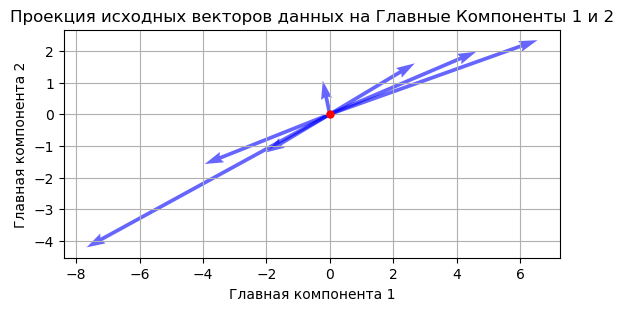

In [20]:
import matplotlib.pyplot as plt
# --- Тесты функций визуализации с данными большей размерности ---
print("\n" + "="*30 + "\n")
print("Тестируем функции визуализации с данными большей размерности:")

# Пример данных: 5 объектов, 4 признака (4D данные)
# Синтетические данные, которые могут иметь основную вариацию в 2 или 3 измерениях
data_list_4d = [
    [1.0, 1.0, 1.0, 1.0],
    [2.0, 2.0, 2.0, 2.0],
    [3.0, 4.0, 5.0, 6.0],
    [4.0, 5.0, 6.0, 7.0],
    [5.0, 6.0, 7.0, 8.0],
    [1.5, 2.5, 3.5, 4.5],
    [0.5, -0.5, -1.5, -2.5],
]
data_matrix_4d =  Matrix(data_list_4d)
print(f"Исходные данные (4D):\n{data_matrix_4d}")

# Применяем PCA для k=2 (снижение размерности до 2D)
k_4d_to_2d = 2
proj_data_4d_to_2d, explained_var_4d_to_2d = pca(data_matrix_4d, k_4d_to_2d)

print(f"\nРезультат PCA (4D -> 2D):")
print(f"Проекция данных (2D):\n{proj_data_4d_to_2d}")
print(f"Доля объяснённой дисперсии: {explained_var_4d_to_2d:.4f}")

# Визуализируем проекцию в 2D
fig_2d_projection = plot_pca_projection(data_matrix_4d, proj_data_4d_to_2d)
print("\nСоздан объект Figure для 2D проекции.")






Результат PCA (4D -> 3D):
Проекция данных (3D):
[
 [ -3.9448 -1.5694 -0.11586]
 [ -2.0101 -1.2045  0.13078]
 [  2.6802  1.6059 -0.17437]
 [  4.6148  1.9709 0.072265]
 [  6.5494  2.3359  0.31890]
 [-0.22177  1.0585 -0.54432]
 [ -7.6678 -4.1973  0.31261]
]
Доля объяснённой дисперсии: 0.9974

Создан объект Figure для 3D проекции.


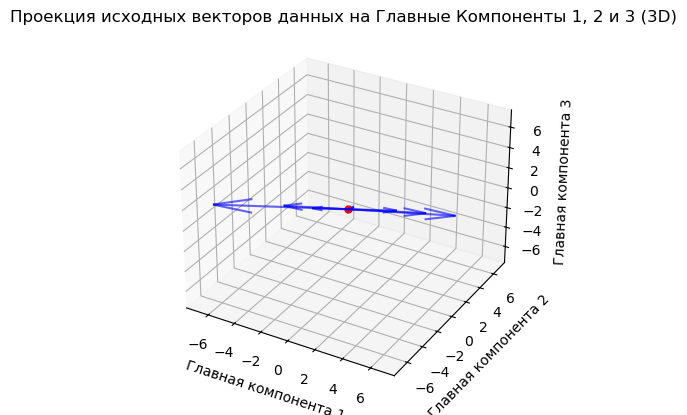

In [21]:

# Применяем PCA для k=3 (снижение размерности до 3D)
k_4d_to_3d = 3
proj_data_4d_to_3d, explained_var_4d_to_3d = pca(data_matrix_4d, k_4d_to_3d)

print(f"\nРезультат PCA (4D -> 3D):")
print(f"Проекция данных (3D):\n{proj_data_4d_to_3d}")
print(f"Доля объяснённой дисперсии: {explained_var_4d_to_3d:.4f}")

# Визуализируем проекцию в 3D
fig_3d_projection = plot_pca_3d_projection(data_matrix_4d, proj_data_4d_to_3d)
print("\nСоздан объект Figure для 3D проекции.")

### MSE


In [22]:
def reconstruction_error(X_orig: "Matrix", X_recon: "Matrix") -> float:
    """
    Вычисляет среднеквадратическую ошибку (MSE) между исходными и восстановленными данными.

    Вход:
    X_orig: исходная матрица данных (n×m)
    X_recon: восстановленная матрица данных (n×m)
    Выход: среднеквадратическая ошибка MSE (вещественное число >= 0)
    """
    if X_orig.size != X_recon.size:
        raise ValueError(
            "Размеры исходной и восстановленной матриц должны совпадать для вычисления ошибки реконструкции."
        )

    n, m = X_orig.size
    if n == 0 or m == 0:
        return 0.0  # MSE is 0 if there are no elements

    squared_diff_sum = 0.0

    # Вычисляем сумму квадратов разностей поэлементно
    for i in range(n):
        for j in range(m):
            # Преобразуем в float для стандартных арифметических операций
            diff = float(X_orig[i, j]) - float(X_recon[i, j])
            squared_diff_sum += diff**2

    # Вычисляем MSE: сумма квадратов разностей, деленная на общее количество элементов
    mse = squared_diff_sum / (n * m)

    return mse


In [23]:
# --- Тесты функции reconstruction_error ---
print("\n" + "=" * 30 + "\n")
print("Тестируем функцию reconstruction_error (MSE):")

# Пример 1: Матрицы идентичны (MSE = 0)
orig_matrix_1 = Matrix([[1.0, 2.0], [3.0, 4.0]])
recon_matrix_1 = Matrix([[1.0, 2.0], [3.0, 4.0]])
mse_1 = reconstruction_error(orig_matrix_1, recon_matrix_1)
print(f"Исходная матрица 1:\n{orig_matrix_1}")
print(f"Восстановленная матрица 1:\n{recon_matrix_1}")
print(f"MSE (должно быть ~0.0): {mse_1:.6f}")
# Ожидаемо: 0.0

print("\n")

# Пример 2: Матрицы отличаются
orig_matrix_2 = Matrix([[1.0, 2.0], [3.0, 4.0]])
recon_matrix_2 = Matrix([[1.1, 1.9], [3.1, 3.9]])
mse_2 = reconstruction_error(orig_matrix_2, recon_matrix_2)
print(f"Исходная матрица 2:\n{orig_matrix_2}")
print(f"Восстановленная матрица 2:\n{recon_matrix_2}")
print(f"MSE (должно быть ~0.01): {mse_2:.6f}")
# Ожидаемо: 0.01

print("\n")




Тестируем функцию reconstruction_error (MSE):
Исходная матрица 1:
[
 [1.0 2.0]
 [3.0 4.0]
]
Восстановленная матрица 1:
[
 [1.0 2.0]
 [3.0 4.0]
]
MSE (должно быть ~0.0): 0.000000


Исходная матрица 2:
[
 [1.0 2.0]
 [3.0 4.0]
]
Восстановленная матрица 2:
[
 [1.1 1.9]
 [3.1 3.9]
]
MSE (должно быть ~0.01): 0.010000




## Expert


### Автоматический выбор числа главных компонент на основе порога объяснённой дисперсии


In [24]:
def auto_select_k(eigenvalues: List[float], threshold: float = 0.95) -> int:
    """
    Вход:
    eigenvalues: список собственных значений
    threshold: порог объяснённой дисперсии
    Выход: оптимальное число главных компонент k
    """
    if not 0.0 < threshold <= 1.0:
        raise ValueError("Threshold должен быть в диапазоне (0, 1].")
    if not eigenvalues:
        # Нет собственных значений - нет компонент
        return 0
    if any(ev < -1e-9 for ev in eigenvalues):# Учитываем погрешность  
         raise ValueError("Собственные значения не могут быть отрицательными.")
    
    # Сортируем собственные значения по убыванию
    sorted_eigenvalues = sorted(eigenvalues, reverse=True)

    total_variance = sum(sorted_eigenvalues)

    # Обработка случая, когда общая дисперсия равна нулю
    if total_variance < 1e-12:
        return 0

    current_variance_sum = 0.0
    k = 0
    for eigenvalue in sorted_eigenvalues:
        # Добавляем неотрицательное собственное значение
        current_variance_sum += max(0.0, eigenvalue)
        k += 1
        explained_variance_ratio = current_variance_sum / total_variance
        if explained_variance_ratio >= threshold:
            return k
    return len(sorted_eigenvalues)


In [25]:
# Для тестов и результатов

eigenvalues_example = [4.5, 2.1, 0.9, 0.3, 0.1, 0.05]

# Найти k для объяснения >= 90% дисперсии
k_90 = auto_select_k(eigenvalues_example, threshold=0.90)
print(f"Для 90% дисперсии нужно k = {k_90}") # Ожидаем 3

# Найти k для объяснения >= 99% дисперсии
k_99 = auto_select_k(eigenvalues_example, threshold=0.99) # Ожидаем 5
print(f"Для 99% дисперсии нужно k = {k_99}") 

k_50 = auto_select_k(eigenvalues_example, threshold=0.50)
print(f"Для 50% дисперсии нужно k = {k_50}") # Ожидаем 1

# Краевой случай: порог 1.0
k_100 = auto_select_k(eigenvalues_example, threshold=1.0)
print(f"Для 100% дисперсии нужно k = {k_100}") # Ожидаемый результат: 6

# Краевой случай: нулевые собственные значения
eigenvalues_zero = [0.0, 0.0, 0.0]
k_zero = auto_select_k(eigenvalues_zero, threshold=0.95)
print(f"Для нулевых собственных значений k = {k_zero}") # Ожидаемый результат: 0

Для 90% дисперсии нужно k = 3
Для 99% дисперсии нужно k = 5
Для 50% дисперсии нужно k = 1
Для 100% дисперсии нужно k = 6
Для нулевых собственных значений k = 0


### Обработать пропущенные значения в данных


In [ ]:
# Перенес реализацию в функцию матрицы и использую в init 
    

### Влияние шума на PCA


In [28]:
def add_noise_and_compare(X: 'Matrix', noise_level: float = 0.1):
    """
    Вход:
    X: матрица данных (n×m)
    noise_level: уровень шума (доля от стандартного отклонения)
    Выход: результаты PCA до и после добавления шума.
    В этом задании можете проявить творческие способности, поэтому выходные данные не
    ,→ типизированы.
    """
    pass

In [29]:
# Для тестов и результатов работы

### PCA к реальному датасету


In [30]:
# Для импорттов

In [31]:
# Для загрузки

In [32]:
def apply_pca_to_dataset(dataset_name: str, k: int) -> Tuple['Matrix', float]:
    """
    Вход:
    dataset_name: название датасета
    k: число главных компонент
    Выход: кортеж (проекция данных, качество модели)
    """
    pass

NameError: name 'Tuple' is not defined

In [ ]:
# Применение и результаты